In [1]:
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
import cv2
import os
# from utils.dataloader import SceneDataset, scene_collate
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

In [2]:
train_data_path = "data/eth_ucy/pickles/ynet_processed/zara2_train.pkl"
val_data_path = "data/eth_ucy/pickles/ynet_processed/zara2_test.pkl"
homo_mat_path = "data/eth_ucy/homo_mat/"

homo_mat = {}
for scene in [
    "eth",
    "hotel",
    "students001",
    "students003",
    "uni_examples",
    "zara1",
    "zara2",
    "zara3",
]:
    homo_mat[scene] = torch.Tensor(
        np.loadtxt(homo_mat_path + f"{scene}_H.txt")
    )
seg_mask = True

In [3]:
resize = 1
obs_len = 8
pred_len = 12
total_len = 20
batch_size = 8

df_train = pd.read_pickle(train_data_path)
df_val = pd.read_pickle(val_data_path)

In [4]:
class SceneDataset(Dataset):
	def __init__(self, data, resize, total_len):
		""" Dataset that contains the trajectories of one scene as one element in the list. It doesn't contain the
		images to save memory.
		:params data (pd.DataFrame): Contains all trajectories
		:params resize (float): image resize factor, to also resize the trajectories to fit image scale
		:params total_len (int): total time steps, i.e. obs_len + pred_len
		"""

		self.trajectories, self.meta, self.scene_list = self.split_trajectories_by_scene(data, total_len)
		self.trajectories = self.trajectories * resize

	def __len__(self):
		return len(self.trajectories)

	def __getitem__(self, idx):
		trajectory = self.trajectories[idx]
		meta = self.meta[idx]
		scene = self.scene_list[idx]
		return trajectory, meta, scene

	def split_trajectories_by_scene(self, data, total_len):
		trajectories = []
		meta = []
		scene_list = []
		for meta_id, meta_df in tqdm(data.groupby('sceneId', as_index=False), desc='Prepare Dataset'):
			trajectories.append(meta_df[['x', 'y']].to_numpy().astype('float32').reshape(-1, total_len, 2))
			meta.append(meta_df)
			scene_list.append(meta_df.iloc()[0:1].sceneId.item())
		return np.array(trajectories, dtype=object), meta, scene_list

def scene_collate(batch):
	trajectories = []
	meta = []
	scene = []
	for _batch in batch:
		trajectories.append(_batch[0])
		meta.append(_batch[1])
		scene.append(_batch[2])
	return torch.Tensor(trajectories).squeeze(0), meta, scene[0]

train_dataset = SceneDataset(
    df_train, resize=resize, total_len=total_len
)
train_loader = DataLoader(
    train_dataset,
    batch_size=1,
    collate_fn=scene_collate,
)

Prepare Dataset: 100%|██████████| 7/7 [00:00<00:00, 80.11it/s]


In [5]:
for batch, (trajectory, meta, scene) in enumerate(train_loader):
    for i in range(0, len(trajectory), batch_size):
        observed = trajectory[i : i + batch_size, :obs_len, :]       # (batch_size, obs_len, 2)
        gt_future = trajectory[i : i + batch_size, obs_len:]
        
        print(observed.shape)
        
    break

torch.Size([8, 8, 2])
torch.Size([8, 8, 2])
torch.Size([8, 8, 2])
torch.Size([8, 8, 2])
torch.Size([8, 8, 2])
torch.Size([8, 8, 2])
torch.Size([8, 8, 2])
torch.Size([8, 8, 2])
torch.Size([8, 8, 2])
torch.Size([8, 8, 2])
torch.Size([8, 8, 2])
torch.Size([8, 8, 2])
torch.Size([8, 8, 2])
torch.Size([8, 8, 2])
torch.Size([8, 8, 2])
torch.Size([8, 8, 2])
torch.Size([8, 8, 2])
torch.Size([8, 8, 2])
torch.Size([8, 8, 2])
torch.Size([8, 8, 2])
torch.Size([8, 8, 2])
torch.Size([8, 8, 2])
torch.Size([5, 8, 2])


/tmp/ipykernel_45241/2064198467.py:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  return torch.Tensor(trajectories).squeeze(0), meta, scene[0]


(480, 640, 3)


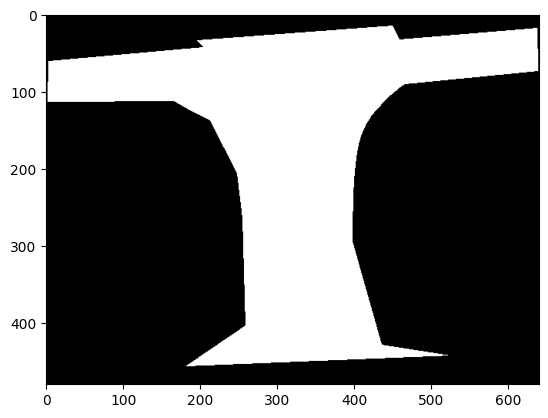

In [10]:
def create_images_dict(image_path, image_file='oracle.png'):
    images = {}
    if image_file == 'oracle.png':
        for scene in [
                "eth",
                "hotel",
                "students001",
                "students003",
                "uni_examples",
                "zara1",
                "zara2",
                "zara3",
            ]:
            im = cv2.imread(os.path.join(image_path, scene, image_file), 0)
            images[scene] = im
    # else:
    #     im = cv2.imread(os.path.join(image_path, scene, image_file))
    return images

img_path = "data/eth_ucy/semantic_map"
test_images = create_images_dict(img_path)
# test_images['eth']

def semantic2rgb(semantic_image):
    # semantic_image = tensor2array(semantic_image)
    semantic_image = np.expand_dims(semantic_image, -1).repeat(3, axis=-1)
    print(semantic_image.shape)
    semantic_image[semantic_image == 0] = 0
    semantic_image[semantic_image == 1] = 255
    return semantic_image

test_img = semantic2rgb(test_images['eth'])
plt.imshow(test_img)

In [ ]:
import segmentation_models_pytorch as smp
def preprocess_image_for_segmentation(
    images, encoder="resnet101", encoder_weights="imagenet", seg_mask=False, classes=6
):
    """Preprocess image for pretrained semantic segmentation, input is dictionary containing images
    In case input is segmentation map, then it will create one-hot-encoding from discrete values
    """

    preprocessing_fn = smp.encoders.get_preprocessing_fn(encoder, encoder_weights)

    for key, im in images.items():
        if seg_mask:
            im = [(im == v) for v in range(classes)]
            im = np.stack(im, axis=-1)  # .astype('int16')
        else:
            im = preprocessing_fn(im)
        im = im.transpose(2, 0, 1).astype("float32")
        im = torch.Tensor(im)
        images[key] = im
        
preprocess_image_for_segmentation(test_images, seg_mask=True, classes=2)

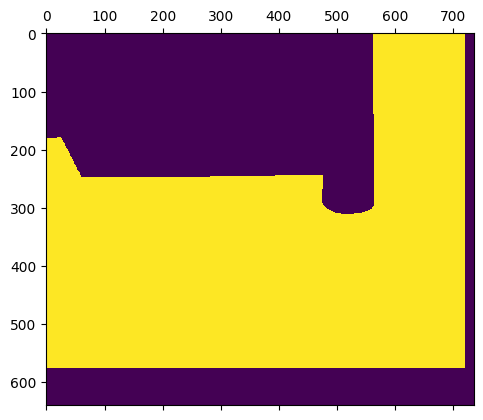

In [ ]:
plt.matshow(test_images['zara2'][1])